In [1]:
import shap
import pickle
import matplotlib.pyplot as plt
from itertools import product
from more_itertools import gray_product
import numpy as np
import pandas as pd

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


ModuleNotFoundError: No module named 'more_itertools'

In [ ]:
with open("./data/obj_v2", "rb") as obj_file:
    obj = pickle.load(obj_file)

In [3]:
model_xgb = obj[0]
data = obj[1]

In [4]:
data

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,1,22.0,1,0,7.2500,7,2,0
1,1,0,38.0,1,0,71.2833,2,0,1
2,3,0,26.0,0,0,7.9250,7,2,1
3,1,0,35.0,1,0,53.1000,2,2,1
4,3,1,35.0,0,0,8.0500,7,2,0
...,...,...,...,...,...,...,...,...,...
707,3,0,39.0,0,5,29.1250,7,1,0
708,2,1,27.0,0,0,13.0000,7,2,0
709,1,0,19.0,0,0,30.0000,1,2,1
710,1,1,26.0,0,0,30.0000,2,0,1


In [5]:
colors = ["brown", "teal", "blue", "coral", "limegreen"]

In [6]:
def create_variable_list(col):
    min_val = col.min()
    max_val = col.max()

    unique = col.unique()

    if len(unique) < 50:
        col_vals = sorted(list(unique))
    else:
        delta = (max_val - min_val) / 100
        col_vals = []
        while min_val <= max_val:
            col_vals.append(min_val)
            min_val += delta
    return col_vals

In [7]:
def top5_find_by_importance(explainer, data):
    shap_values = explainer(data).values

    col_names = []
    indexes = []
    mean_importance = list(np.mean(np.absolute(shap_values), axis=0))

    max_list = sorted(mean_importance)[-5:]
    for max_val in max_list:
        indexes.append(mean_importance.index(max_val))
        col_names.append(data.columns[mean_importance.index(max_val)])

    return col_names, indexes

In [8]:
def top5_centered_importance(explainer, data, col_name):
    data_copy = data.copy()

    col_vals = create_variable_list(data[col_name])
    res_vals = []

    for val in col_vals:
        new_col = len(data_copy[col_name]) * [val]
        data_copy[col_name] = new_col
        shap_values = explainer(data_copy).values
        res_vals.append(shap_values)

    return res_vals, col_vals

In [9]:
def plot_top5_centered_importance(model, data, col_name, absolute=False):
    plot = plt.axes()
    plot.figure.set_size_inches(16, 8)

    if absolute:
        title = "Центрированный график изменения абсолютной важности переменных"
    else:
        title = "Центрированный график изменения важности переменных"
    plot.set_title(title, fontsize=18)

    explainer = shap.TreeExplainer(model)

    data_copy = data.copy()
    if "Survived" in data.columns:
        data_copy = data_copy.drop("Survived", axis=1)

    cols, indexes = top5_find_by_importance(explainer, data_copy)

    res_vals, col_vals = top5_centered_importance(explainer, data_copy, col_name)

    res_vals = np.array(res_vals)

    for i in range(0, len(indexes)):
        res = []

        for j in range(0, len(res_vals)):
            val = res_vals[j, :, indexes[i]]
            if absolute:
                val = np.absolute(val)
            res.append(val.mean())

        plot.plot(col_vals, res, color=colors[i], linewidth=4, label=cols[i])

    plot.grid()
    plot.set_xlabel(col_name, fontsize=16)
    plot.set_ylabel("Важность переменных", fontsize=16)
    plot.legend()

    return plot

<Axes: title={'center': 'Центрированный график изменения важности переменных'}, xlabel='Sex', ylabel='Важность переменных'>

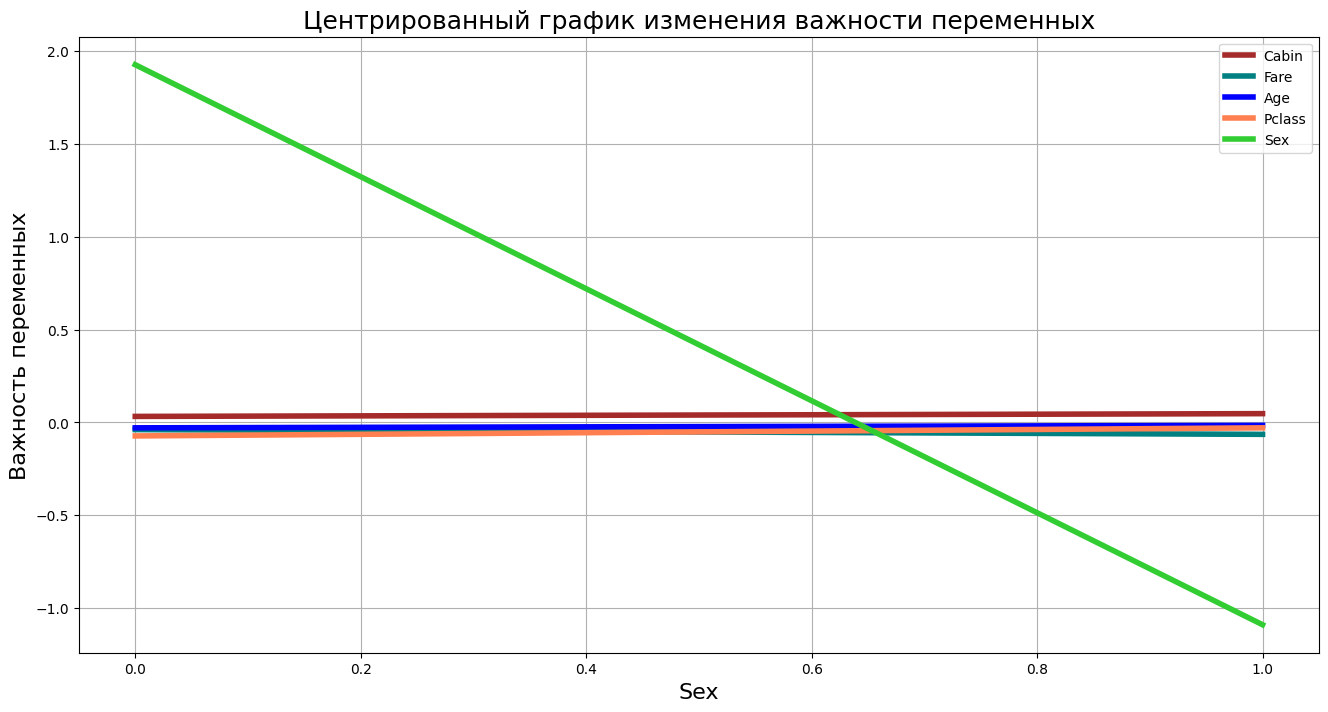

In [12]:
plot_top5_centered_importance(model_xgb, data, "Sex")

In [7]:
df = data.copy()

In [7]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,1,22.0,1,0,7.2500,7,2,0
1,1,0,38.0,1,0,71.2833,2,0,1
2,3,0,26.0,0,0,7.9250,7,2,1
3,1,0,35.0,1,0,53.1000,2,2,1
4,3,1,35.0,0,0,8.0500,7,2,0


In [8]:
df.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.240169,0.636236,29.642093,0.514045,0.432584,34.567251,5.825843,1.595506,0.404494
std,0.836854,0.481420,14.492933,0.930692,0.854181,52.938648,2.136155,0.779038,0.491139
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,20.000000,0.000000,0.000000,8.050000,5.750000,2.000000,0.000000
50%,2.000000,1.000000,28.000000,0.000000,0.000000,15.645850,7.000000,2.000000,0.000000
75%,3.000000,1.000000,38.000000,1.000000,1.000000,33.000000,7.000000,2.000000,1.000000
max,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,8.000000,2.000000,1.000000


In [20]:
df = df.drop("Survived", axis=1)

In [ ]:
df = df.drop("Fare", axis=1)


In [78]:
def create_dataset_with_full_coverage(df):
    creation_data = get_df_values_for_creation(df.to_dict(), 1)
    test(creation_data)
    product_result = product(*list(creation_data.values()))
    res_df = pd.DataFrame(product_result, columns=df.columns)
    return res_df

In [79]:
res_df = create_dataset_with_full_coverage(df)

3
6
480
2880
20160
60480
544320
1632960


In [74]:
col_name = "Age"

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
data_copy = res_df.copy()
shap_values = explainer(data_copy).values
mean_importance = list(np.mean(np.absolute(shap_values), axis=0))
max_list = sorted(mean_importance)[-5:]
cols = []
indexes = []
for max_val in max_list:
    indexes.append(mean_importance.index(max_val))
    cols.append(data.columns[mean_importance.index(max_val)])
col_vals = list(set(data[col_name].values))
col_vals

<Axes: title={'center': 'Центрированный график изменения важности переменных'}, xlabel='Age', ylabel='Важность переменных'>

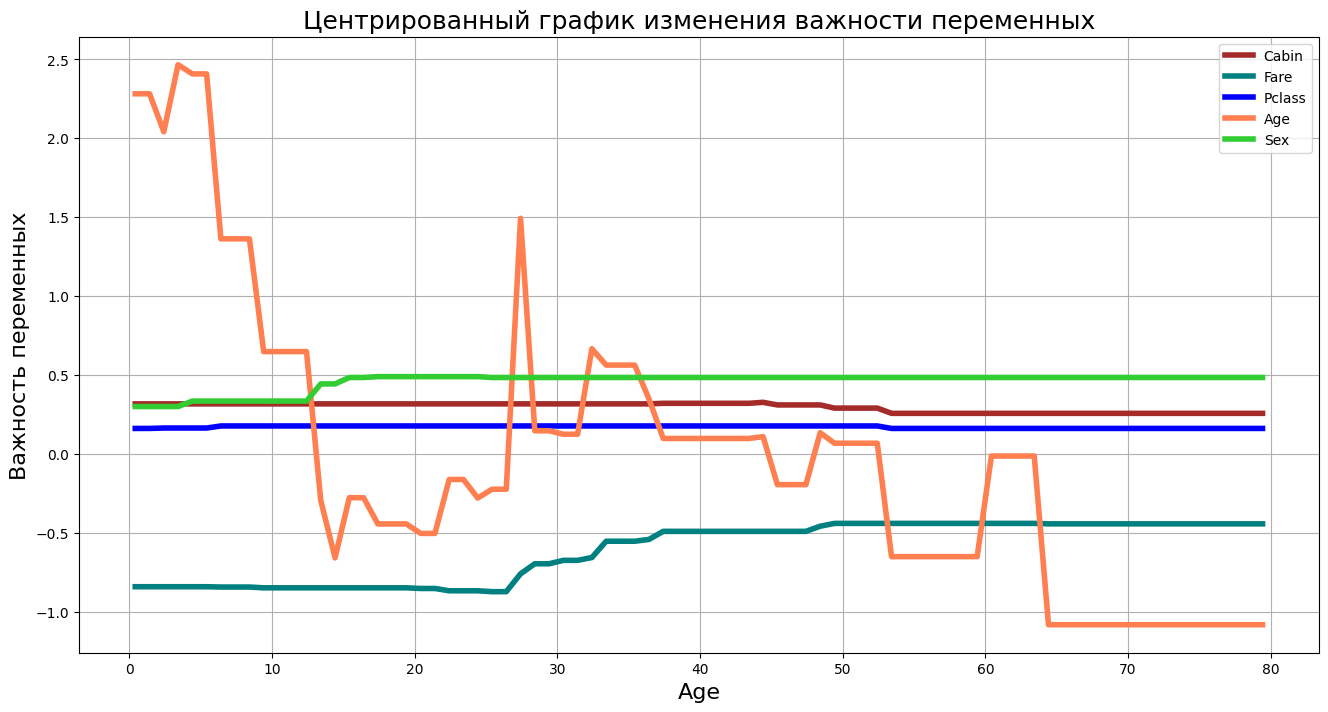

In [80]:
plot_top5_centered_importance_v2(model_xgb, res_df, "Age")

In [69]:
max_list

[0.41616586, 0.6294607, 0.6687761, 0.7147785, 1.5367968]

In [76]:
def plot_top5_centered_importance_v2(model, data, col_name, absolute=False):
    plot = plt.axes()
    plot.figure.set_size_inches(16, 8)

    if absolute:
        title = "Центрированный график изменения абсолютной важности переменных"
    else:
        title = "Центрированный график изменения важности переменных"
    plot.set_title(title, fontsize=18)

    explainer = shap.TreeExplainer(model)

    data_copy = data.copy()
    if "Survived" in data.columns:
        data_copy = data_copy.drop("Survived", axis=1)

    shap_values = explainer(data_copy).values

    cols = []
    indexes = []
    mean_importance = list(np.mean(np.absolute(shap_values), axis=0))

    max_list = sorted(mean_importance)[-5:]
    for max_val in max_list:
        indexes.append(mean_importance.index(max_val))
        cols.append(data.columns[mean_importance.index(max_val)])

    col_vals = list(sorted(set(data[col_name].values)))
    res_vals = []

    for val in col_vals:
        new_col = len(data_copy[col_name]) * [val]
        data_copy[col_name] = new_col
        shap_values = explainer(data_copy).values
        res_vals.append(shap_values)


    res_vals = np.array(res_vals)

    for i in range(0, len(indexes)):
        res = []

        for j in range(0, len(res_vals)):
            val = res_vals[j, :, indexes[i]]
            if absolute:
                val = np.absolute(val)
            res.append(val.mean())

        plot.plot(col_vals, res, color=colors[i], linewidth=4, label=cols[i])

    plot.grid()
    plot.set_xlabel(col_name, fontsize=16)
    plot.set_ylabel("Важность переменных", fontsize=16)
    plot.legend()

    return plot

In [57]:
def get_df_values_for_creation(data, delta=25):
    result = {}
    for key, data in data.items():
        unique_data = set(data.values())
        if key == "Fare":
            result[key] = [10, 250, 500]
        elif len(unique_data) <= 10:
            result[key] = list(sorted(unique_data))
        else:
            result[key] = generate_values(min(unique_data), max(unique_data), delta)
    return result

In [8]:
def generate_values(min_val: float, max_val: float, delta: float) -> list[float]:
    values = []
    current_val = min_val
    while current_val <= max_val:
        values.append(current_val)
        current_val += delta
    return values

In [45]:
# Расчёт числа элементов декартового произведения
def test(creation_data):
    count = 1
    for key, values in creation_data.items():
        count *= len(values)
        print(count)

In [ ]:
plot = plt.axes()

res_vals, col_vals = ice_plot_data_y(model, data, col_name)
y_label = 'Вероятность удачного исхода'
title = f'с-ICE график вероятности удачного исхода при изменении переменной {col_name}'

df = pd.DataFrame(np.array(res_vals))
df = df.T
mean = df.mean()

plot.figure.set_size_inches(16, 8)
plot.set_title(title, fontsize=18)

for i in df.index:
    plot.plot(col_vals, df.loc[i], color='black', linewidth=0.1)

plot.plot(col_vals, mean, color='lime', linewidth=6)

plot.grid()
plot.set_xlabel(col_name, fontsize=16)
plot.set_ylabel(y_label, fontsize=16)


In [ ]:
plot_ice_plot(model_xgb, res_df, "Age")

<Axes: title={'center': 'с-ICE график вероятности удачного исхода при изменении переменной Age'}, xlabel='Age', ylabel='Вероятность удачного исхода'>

In [85]:
def ice_plot_data_y(model, data, col_name):
    data_copy = data.copy()

    col_vals = list(sorted(set(data[col_name].values)))
    res_vals = []

    for val in col_vals:
        new_col = len(data_copy[col_name]) * [val]
        data_copy[col_name] = new_col
        predict = model.predict_proba(data_copy)[:, 1]
        res_vals.append(predict)

    return res_vals, col_vals

In [86]:
def plot_ice_plot(model, data, col_name, importance=False):
    plot = plt.axes()

    if importance:
        explainer = shap.TreeExplainer(model)
        res_vals, col_vals = ice_plot_data_importance(explainer, data, col_name)
        y_label = f'Важность переменной {col_name}'
        title = f'с-ICE график изменения важности переменной {col_name}'
    else:
        res_vals, col_vals = ice_plot_data_y(model, data, col_name)
        y_label = 'Вероятность удачного исхода'
        title = f'с-ICE график вероятности удачного исхода при изменении переменной {col_name}'

    df = pd.DataFrame(np.array(res_vals))
    df = df.T
    mean = df.mean()

    plot.figure.set_size_inches(16, 8)
    plot.set_title(title, fontsize=18)

    for i in df.index:
        plot.plot(col_vals, df.loc[i], color='black', linewidth=0.1)

    plot.plot(col_vals, mean, color='lime', linewidth=6)

    plot.grid()
    plot.set_xlabel(col_name, fontsize=16)
    plot.set_ylabel(y_label, fontsize=16)

    return plot